In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deem import deem

In [3]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("openmic_classmap_10.json", "r") as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
with open("class_align.json", "r") as f: # only consider 10 classes of Openmic dataset
    class_align = json.load(f)

with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

In [4]:
embedding = 'vggish'
debias_method = ''
feature_dir='./embeddings.h5'

In [12]:
with open("openmic_classmap_10.json", "r") as f: # only consider 10 classes of Openmic dataset
    openmic_map = json.load(f)

embeddings = h5py.File(feature_dir, "r")

###### OpenMIC datat ######
feature = np.array(embeddings["openmic"][embedding]["features"])
keys = np.array(embeddings["openmic"][embedding]["keys"])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

# key-label map using the information from the dataset source
data_root = "openmic-2018/"

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, "openmic-2018.npz"))["Y_true"]
Ymask = np.load(os.path.join(data_root, "openmic-2018.npz"))["Y_mask"]
sample_key = np.load(os.path.join(data_root, "openmic-2018.npz"))["sample_key"]

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

print(feature_clip.shape, Y_true.shape, Y_mask.shape)

# train-test split
train_set = set(pd.read_csv(data_root + "openmic2018_train.csv", header=None, squeeze=True))
test_set = set(pd.read_csv(data_root + "openmic2018_test.csv", header=None, squeeze=True))
print("# Train: {},  # Test: {}".format(len(train_set), len(test_set)))

idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError("Unknown sample key={}! Abort!".format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

meta = pd.read_csv(data_root + "openmic-2018-metadata.csv")
train_genre_meta = list(meta["track_genres"][idx_train])
test_genre_meta = list(meta["track_genres"][idx_test])
len(train_genre_meta), len(test_genre_meta)

(180000, 128) (180000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000,)
(20000, 20) (20000, 20) (20000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000, 20) (20000, 20)
# Train: 14915,  # Test: 5085


(14915, 5085)

In [22]:
meta = pd.read_csv(data_root + "openmic-2018-metadata.csv")
train_genre_meta = list(meta["track_genres"][idx_train])
test_genre_meta = list(meta["track_genres"][idx_test])
len(train_genre_meta), len(test_genre_meta)

(14915, 5085)

In [51]:
idx_genre_train = []
genre_train_openmic = []

for k in tqdm(range(len(train_genre_meta))):
    if isinstance(train_genre_meta[k], str):
        idx_genre_train.append(k)
        genre_excerpt = literal_eval(train_genre_meta[k])
        genre_train_openmic.append([item['genre_title']for item in genre_excerpt])

idx_genre_train = np.array(idx_genre_train)

idx_genre_test = []
genre_test_openmic = []

for k in tqdm(range(len(test_genre_meta))):
    if isinstance(test_genre_meta[k], str):
        idx_genre_test.append(k)
        genre_excerpt = literal_eval(test_genre_meta[k])
        genre_test_openmic.append([item['genre_title']for item in genre_excerpt])

idx_genre_test = np.array(idx_genre_test)

  0%|          | 0/14915 [00:00<?, ?it/s]

  0%|          | 0/5085 [00:00<?, ?it/s]

In [64]:
k = 200
genre_train_openmic[k:k+20]

[['Electronic', 'Indie-Rock'],
 ['Experimental', 'Free-Folk', 'Indie-Rock', 'Americana'],
 ['Experimental', 'Free-Folk', 'Indie-Rock', 'Americana'],
 ['Experimental', 'Free-Folk', 'Indie-Rock', 'Americana'],
 ['Electronic'],
 ['Audio Collage'],
 ['Audio Collage'],
 ['Audio Collage'],
 ['Electronic'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Folk'],
 ['Folk'],
 ['Rock'],
 ['Rock'],
 ['Rock'],
 ['Rock']]

In [50]:
literal_eval(train_genre_meta[13])

[{'genre_id': '17',
  'genre_title': 'Folk',
  'genre_url': 'http://freemusicarchive.org/genre/Folk/'}]

## before

  0%|          | 0/14915 [00:00<?, ?it/s]

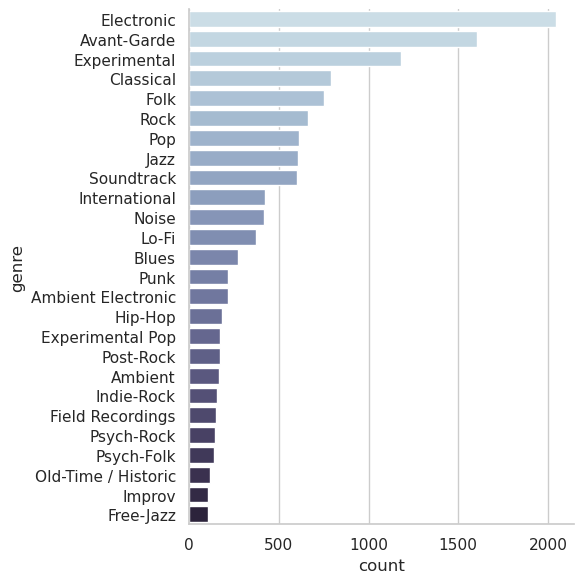

In [6]:
genre_train_openmic = []

for k in tqdm(range(len(train_genre_meta))):
    if isinstance(train_genre_meta[k], str):
        genre_train_openmic.append(literal_eval(train_genre_meta[k])[0]["genre_title"])
        
genre_all = cl.Counter(genre_train_openmic).most_common()
genre_train_openmic_plot = pd.DataFrame(columns=['genre', 'count'])

genre_train_openmic_plot['genre'] = [item[0] for item in genre_all]
genre_train_openmic_plot['count'] = [item[1] for item in genre_all]

genre_plot = genre_train_openmic_plot.loc[(genre_train_openmic_plot['count'] >= 100)]

sns.set_theme(context='notebook', style='whitegrid') # , font_scale=1.6)
sns.catplot(data=genre_plot, x='count', y='genre', kind='bar', height=6, aspect=1,
               legend_out=False, palette="ch:s=.25,rot=-.25")
plt.savefig('results/openmic_train_genre_before.pdf', bbox_inches='tight')

## after

In [9]:
def list_match(A, B):
    ele_A = set(map(str.lower, A))
    ele_B = set(map(str.lower, B))
    return len(ele_A.intersection(ele_B)) > 0

In [13]:
idx_genre_train = []
genre_train_openmic = []

for k in tqdm(range(len(train_genre_meta))):
    if isinstance(train_genre_meta[k], str):
        idx_genre_train.append(k)
        genre_excerpt = literal_eval(train_genre_meta[k])
        genre_train_openmic.append([item['genre_title']for item in genre_excerpt])

idx_genre_train = np.array(idx_genre_train)

idx_genre_test = []
genre_test_openmic = []

for k in tqdm(range(len(test_genre_meta))):
    if isinstance(test_genre_meta[k], str):
        idx_genre_test.append(k)
        genre_excerpt = literal_eval(test_genre_meta[k])
        genre_test_openmic.append([item['genre_title']for item in genre_excerpt])

idx_genre_test = np.array(idx_genre_test)


  0%|          | 0/14915 [00:00<?, ?it/s]

  0%|          | 0/5085 [00:00<?, ?it/s]

In [14]:
genre_train_final = []
for genre_excerpt in genre_train_openmic:
    item_genre = []
    for item in genre_excerpt:
        for genre in genre_map:
            if list_match(re.split("[^a-zA-Z]", item), re.split("[^a-zA-Z]", genre)):
                item_genre.append(genre)
    if len(item_genre) > 0:
        genre_train_final.append(item_genre[0])
    else:
        genre_train_final.append(genre_excerpt[0])
        
genre_test_final = []
for genre_excerpt in genre_test_openmic:
    item_genre = []
    for item in genre_excerpt:
        for genre in genre_map:
            if list_match(re.split("[^a-zA-Z]", item), re.split("[^a-zA-Z]", genre)):
                item_genre.append(genre)
    if len(item_genre) > 0:
        genre_test_final.append(item_genre[0])
    else:
        genre_test_final.append(genre_excerpt[0])

genre_train_openmic, genre_test_openmic = genre_train_final, genre_test_final

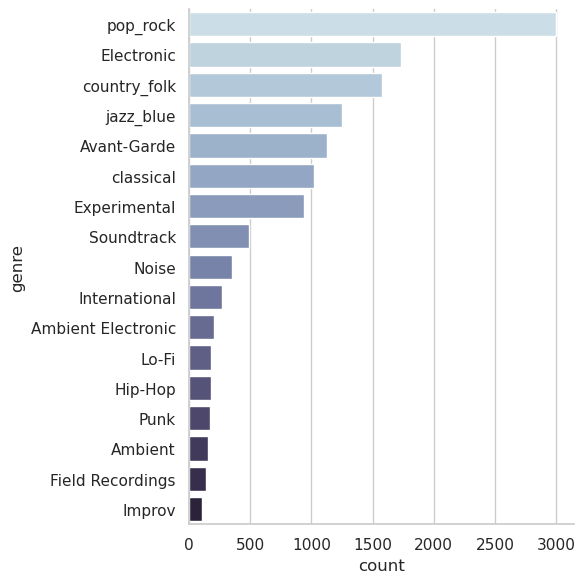

In [15]:
genre_all = cl.Counter(genre_train_openmic).most_common()
genre_train_openmic_plot = pd.DataFrame(columns=['genre', 'count'])

genre_train_openmic_plot['genre'] = [item[0] for item in genre_all]
genre_train_openmic_plot['count'] = [item[1] for item in genre_all]

genre_plot = genre_train_openmic_plot.loc[(genre_train_openmic_plot['count'] >= 100)]

sns.set_theme(context='notebook', style='whitegrid') # , font_scale=1.6)
sns.catplot(data=genre_plot, x='count', y='genre', kind='bar', height=6, aspect=1,
               legend_out=False, palette="ch:s=.25,rot=-.25")
plt.savefig('results/openmic_train_genre_after.pdf', bbox_inches='tight')

In [16]:
## final

In [18]:
genre_train_openmic = np.array([item if item in genre_map else "other" for item in genre_train_openmic])
genre_test_openmic = np.array([item if item in genre_map else "other" for item in genre_test_openmic])

genre_train_openmic = genre_train_openmic[genre_train_openmic!="other"]
genre_test_openmic = genre_test_openmic[genre_test_openmic!="other"]

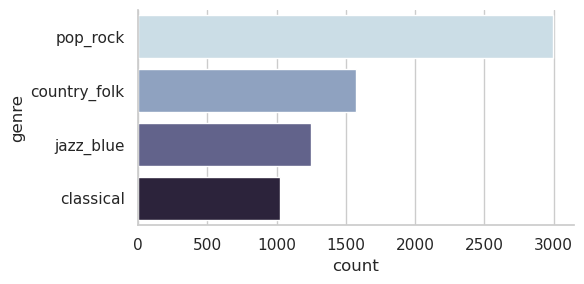

In [21]:
genre_all = cl.Counter(genre_train_openmic).most_common()
genre_train_openmic_plot = pd.DataFrame(columns=['genre', 'count'])

genre_train_openmic_plot['genre'] = [item[0] for item in genre_all]
genre_train_openmic_plot['count'] = [item[1] for item in genre_all]

genre_plot = genre_train_openmic_plot.loc[(genre_train_openmic_plot['count'] >= 100)]

sns.set_theme(context='notebook', style='whitegrid') # , font_scale=1.6)
sns.catplot(data=genre_plot, x='count', y='genre', kind='bar', height=3, aspect=2,
               legend_out=False, palette="ch:s=.25,rot=-.25")
plt.savefig('results/openmic_train_genre_final.pdf', bbox_inches='tight')

In [65]:
genre_plot

,genre,count
0,pop_rock,2996
1,country_folk,1573
2,jazz_blue,1247
3,classical,1022
